In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# # Load example data
# data_df = mavenn.load_example_dataset('sortseq')

# # Separate test from data_df
# ix_test = data_df['set']=='test'
# test_df = data_df[ix_test].reset_index(drop=True)
# print(f'test N: {len(test_df):,}')

# # Remove test data from data_df
# data_df = data_df[~ix_test].reset_index(drop=True)
# print(f'training + validation N: {len(data_df):,}')
# data_df.head()
#pd.read_csv
data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
data_df = data_df_full[['x','SortSeq_bin1','SortSeq_bin2','SortSeq_bin3','SortSeq_bin4']].copy()
data_df.head(10)

,x,SortSeq_bin1,SortSeq_bin2,SortSeq_bin3,SortSeq_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,116,92,21,3
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,158,120,137,15
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,47,234,521,116
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,299,32,1,1
5,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,322,238,196,14
6,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,38,78,181,45
7,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1364,24,43,15
8,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,64,129,122,27
9,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,6,22


In [3]:
y_cols = data_df.columns[1:]

X = data_df['x']
y = data_df[y_cols]

In [4]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [27]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet_star=['A', 'C', 'D', 'E', 'F',
              'G', 'H', 'I', 'K', 'L',
              'M', 'N', 'P', 'Q', 'R',
              'S', 'T', 'V', 'W', 'Y','*']

alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=201, Y=4


In [6]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)


2022-06-01 14:44:48.207450: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create measurement process object(s)

In [7]:
# I think this shouldn't require any positional arguments.
# mp_GE = mavenn.measurement_process_layers.GlobalEpistasisLayer(K=50,
#                                                                eta=1e-5,
#                                                                monotonic=True)
mp_mpa = mavenn.measurement_process_layers.DiscreteMonotonicMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=Y,
                                                                      K=50,
                                                                      eta=1e-5,)


In [8]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_mpa])

In [9]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4024)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4020)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           4021        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [10]:
# Set training data
model.set_data(x=x_train.values,
               y_list=[y_train.values],
               #validation_flags=(data_df['set']=='validation'),
               shuffle=True)


N = 83,880 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 15.6 sec.


In [11]:

# Fit model to data
model.fit(learning_rate=.001,
          epochs=150,
          batch_size=300,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/150
224/224 [==============================] - 3s 9ms/step - loss: 221364.1719 - I_var: -0.0256 - val_loss: 218582.1250 - val_I_var: 3.0801e-04
Epoch 2/150
224/224 [==============================] - 2s 7ms/step - loss: 218630.2969 - I_var: -0.0017 - val_loss: 218560.7031 - val_I_var: 4.6667e-04
Epoch 3/150
224/224 [==============================] - 2s 8ms/step - loss: 218549.2344 - I_var: -8.2982e-04 - val_loss: 218664.9375 - val_I_var: -3.4787e-04
Epoch 4/150
224/224 [==============================] - 2s 9ms/step - loss: 217936.0781 - I_var: 0.0045 - val_loss: 216404.0781 - val_I_var: 0.0192
Epoch 5/150
224/224 [==============================] - 2s 7ms/step - loss: 211979.5000 - I_var: 0.0559 - val_loss: 209010.7812 - val_I_var: 0.0832
Epoch 6/150
224/224 [==============================] - 2s 8ms/step - loss: 203678.0469 - I_var: 0.1271 - val_loss: 203400.5781 - val_I_var: 0.1312
Epoch 7/150
224/224 [==============================] - 2s 10ms/step - loss: 198852.7812 - I_var: 0

In [12]:
x_test

54062    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
10006    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
22116    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
18503    NITNLCPFYEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
26511    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVSYNSASFST...
                               ...                        
57405    NITNLCPFGEVFNRTRFASVYAWNRKRISNCVADYSVLYNSASFST...
50146    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
26419    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSAPFST...
21866    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
55316    NITNLCPFGEVFNLTRFASVYAWNRKRISNCVADWSVLYNSASFST...
Name: x, Length: 9321, dtype: object

On test data:


Text(0.5, 1.0, 'training hisotry')

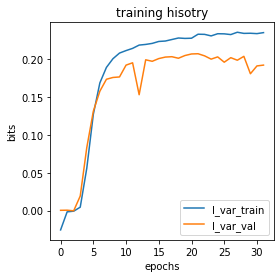

In [13]:
# Show training history
print('On test data:')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

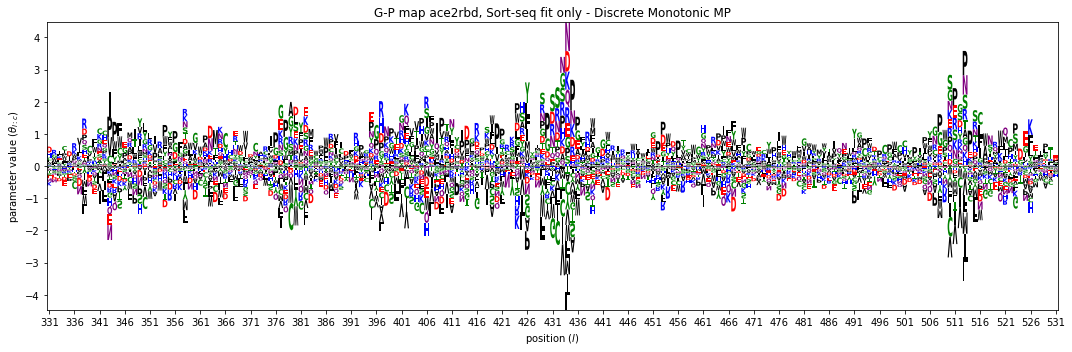

In [26]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(-pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True, color_scheme='chemistry')
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map ace2rbd, Sort-seq fit only - Discrete Monotonic MP')
ax.set_xticks(np.arange(0,201,5))
ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only.png',dpi=300,bbox_inches='tight')
plt.show()

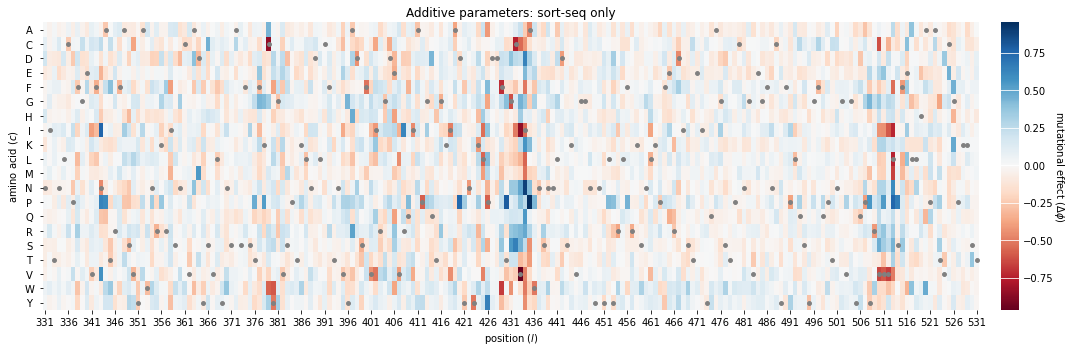

In [15]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=logo.df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters: sort-seq only')
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

In [16]:
bloom_single_mut_df = pd.read_csv('single_mut_effects_Bloom.txt')
bloom_single_mut_df.head(10)

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
0,1,331,N,A,N331A,N1A,-0.05,-0.02,-0.03,-0.14,-0.08,-0.11
1,1,331,N,C,N331C,N1C,-0.08,-0.10,-0.09,-1.56,-0.97,-1.26
2,1,331,N,D,N331D,N1D,0.00,0.07,0.03,-0.75,-0.12,-0.44
3,1,331,N,E,N331E,N1E,0.02,-0.02,0.00,-0.39,-0.24,-0.31
4,1,331,N,F,N331F,N1F,-0.03,-0.16,-0.10,-0.83,-0.57,-0.70
5,1,331,N,G,N331G,N1G,-0.06,-0.02,-0.04,-0.21,-0.29,-0.25
6,1,331,N,H,N331H,N1H,0.01,-0.05,-0.02,-0.86,-0.36,-0.61
7,1,331,N,I,N331I,N1I,-0.06,-0.08,-0.07,-1.05,-0.65,-0.85
8,1,331,N,K,N331K,N1K,-0.01,-0.01,-0.01,-0.17,-0.24,-0.20
9,1,331,N,L,N331L,N1L,-0.08,-0.01,-0.05,-0.81,-0.69,-0.75


In [17]:

bloom_exp_df = pd.DataFrame(columns=alphabet)
for site in range(1,201+1,):

    temp_df = bloom_single_mut_df[bloom_single_mut_df['site_RBD']==site].copy()
    temp_df['expr_lib1']
    bloom_exp_df.loc[site-1] = temp_df['expr_lib1'].values[0:20]




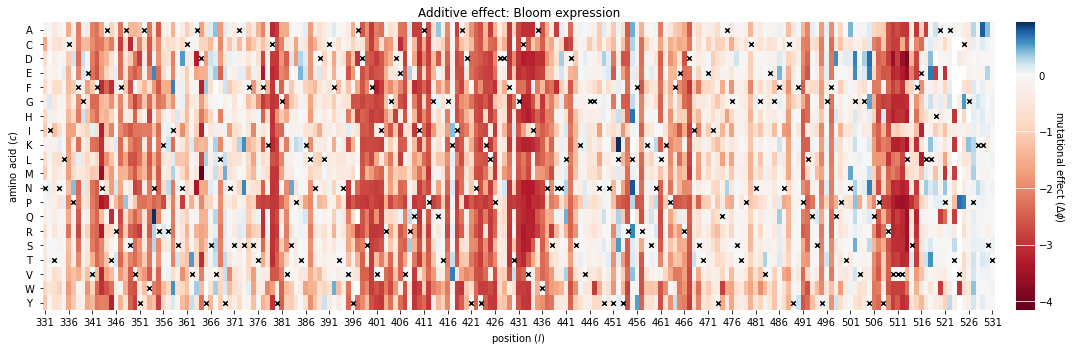

In [18]:
bloom_exp_df
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=bloom_exp_df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'black', 's':20,'marker':'x'},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive effect: Bloom expression')

heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

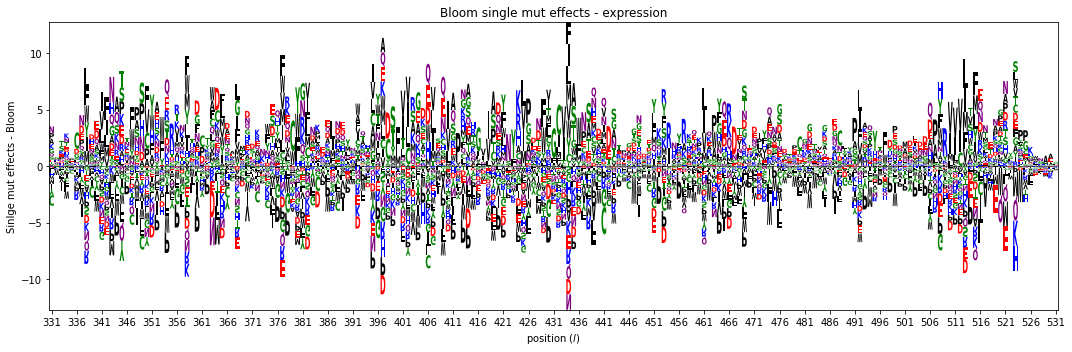

In [33]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(bloom_exp_df.fillna(0), ax=ax,center_values=True, color_scheme='chemistry')
ax.set_ylabel('Sinlge mut effects - Bloom')
ax.set_xlabel(r'position ($l$)')
ax.set_title('Bloom single mut effects - expression')
ax.set_xticks(np.arange(0,201,5))
ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only.png',dpi=300,bbox_inches='tight')
plt.show()

In [34]:
theta

array([[-0.19917   , -0.28144252, -0.37771505, ..., -0.14796081,
        -0.24404885, -0.21112387],
       [ 0.09581362,  0.09020116,  0.13153557, ...,  0.05387881,
        -0.04110869,  0.0916278 ],
       [-0.16062081, -0.17847314, -0.04738831, ..., -0.1202613 ,
        -0.17805697, -0.12487451],
       ...,
       [ 0.11548245,  0.05984535, -0.12571885, ..., -0.05068136,
         0.0184553 , -0.16280308],
       [ 0.13907081,  0.20668355,  0.13280731, ...,  0.14164709,
         0.08974927,  0.03041378],
       [-0.0651712 , -0.00359418, -0.14186811, ..., -0.04163476,
        -0.03050463, -0.0462942 ]], dtype=float32)

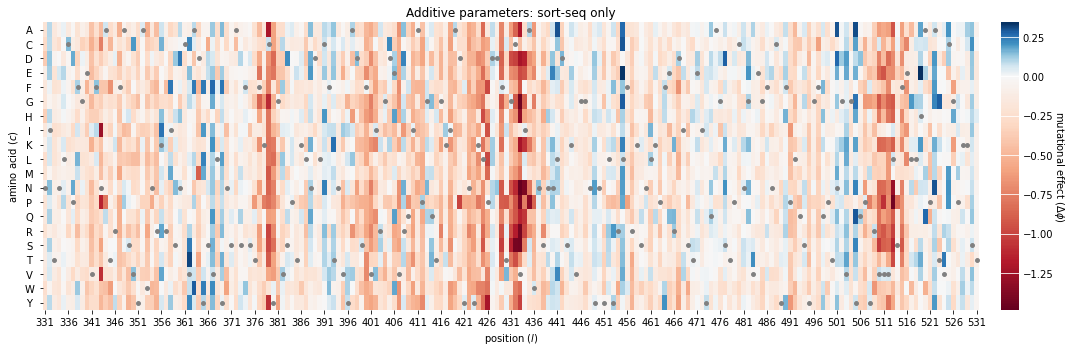

In [19]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=theta,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters: sort-seq only')
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

In [20]:
theta_raw_df = pd.DataFrame(np.squeeze(gpmap.weights[1].numpy()),columns=alphabet)
theta_raw_df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,-0.199170,-0.281443,-0.377715,-0.100492,-0.165062,-0.175315,-0.348450,-0.168160,-0.074995,-0.251332,-0.210960,-0.087851,-0.204817,-0.159465,-0.209617,-0.122798,-0.123678,-0.147961,-0.244049,-0.211124
1,0.095814,0.090201,0.131536,0.116109,0.017556,-0.043964,0.092132,0.025203,0.061399,0.058450,-0.025069,0.143940,0.046712,0.108342,-0.096532,0.107947,0.044165,0.053879,-0.041109,0.091628
2,-0.160621,-0.178473,-0.047388,-0.205913,-0.210655,-0.115945,-0.122354,-0.240145,-0.206062,-0.202517,-0.149420,-0.098573,-0.072389,-0.101882,-0.160879,-0.081315,-0.068218,-0.120261,-0.178057,-0.124875
3,-0.075054,-0.259126,-0.009443,0.055907,-0.194171,-0.065127,-0.092941,-0.209826,-0.101090,-0.128070,-0.094827,-0.080754,-0.208010,-0.108519,-0.071934,-0.123268,-0.060417,-0.198410,-0.203567,-0.185357
4,0.022732,-0.006038,-0.158327,0.098234,0.016840,0.055338,0.007148,-0.140025,0.053105,-0.012843,-0.079103,0.035778,0.098525,-0.000606,-0.040813,-0.006077,0.023976,0.005909,-0.030215,0.024808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.018746,-0.117181,-0.027857,-0.215210,-0.115565,0.073010,0.022152,0.053559,-0.023963,0.011635,0.118553,-0.055280,-0.085328,-0.104303,-0.030700,-0.058637,-0.173707,-0.007531,-0.084838,0.019657
197,0.016120,-0.022607,-0.015727,0.030888,-0.079245,-0.006908,-0.008660,-0.114904,-0.012196,0.027428,-0.037122,-0.019065,-0.074219,0.070341,-0.028558,0.030920,0.024027,0.088076,0.115987,0.078106
198,0.115482,0.059845,-0.125719,-0.105902,-0.079027,-0.164834,0.010689,-0.100382,-0.097542,-0.199106,-0.054595,0.003156,-0.233244,-0.001128,-0.073301,-0.029827,-0.117419,-0.050681,0.018455,-0.162803
199,0.139071,0.206684,0.132807,0.127131,0.031201,0.120982,0.094475,0.130166,0.066615,0.036234,0.068921,0.078381,0.112592,0.133538,0.019721,0.071058,-0.287424,0.141647,0.089749,0.030414


In [21]:
# del bloom_exp_df['*']
# del theta_raw_df['*']

Text(0, 0.5, 'MAVE-NN2, G-P map')

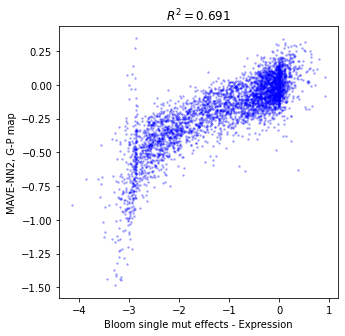

In [22]:
plt.figure(figsize=(5,5))
Rsq = np.corrcoef(bloom_exp_df.fillna(0).values.ravel(),theta_raw_df.fillna(0).values.ravel())[0,1]**2
#Rsq = np.corrcoef(bloom_exp_df.values, logo.df.values)[0,1]**2
#plt.scatter(theta_raw_df.values, -logo.df.values,s=5,alpha=0.25,color='red')
plt.scatter(bloom_exp_df.values, theta_raw_df.values,s=2.5,alpha=0.25,color='blue')

#lims = [-3,1]
#plt.plot(lims,lims,'--')
plt.xlabel('Bloom single mut effects - Expression')
plt.title(f'$R^2 = {Rsq:.3f}$')
plt.ylabel('MAVE-NN2, G-P map')

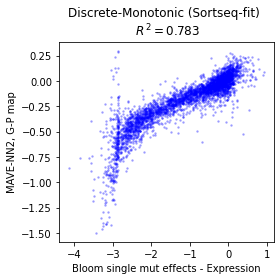

In [23]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

plt.figure(figsize=(4,4))
Rsq = np.corrcoef(bloom_exp_df.fillna(0).values.ravel(),theta_lc_consensus_df.fillna(0).values.ravel())[0,1]**2
#Rsq = np.corrcoef(bloom_exp_df.values, logo.df.values)[0,1]**2
#plt.scatter(theta_raw_df.values, -logo.df.values,s=5,alpha=0.25,color='red')
plt.scatter(bloom_exp_df.values.ravel(), theta_lc_consensus_df.values.ravel(),s=2.5,alpha=0.25,color='blue')

#lims = [-3,1]
#plt.plot(lims,lims,'--')
plt.xlabel('Bloom single mut effects - Expression')
plt.title(f'Discrete-Monotonic (Sortseq-fit) \n $R^2 = {Rsq:.3f}$')
plt.ylabel('MAVE-NN2, G-P map')
plt.tight_layout()
plt.savefig('mavenn_bloom_expression_comparison.png',dpi=200,bbox_inches='tight')

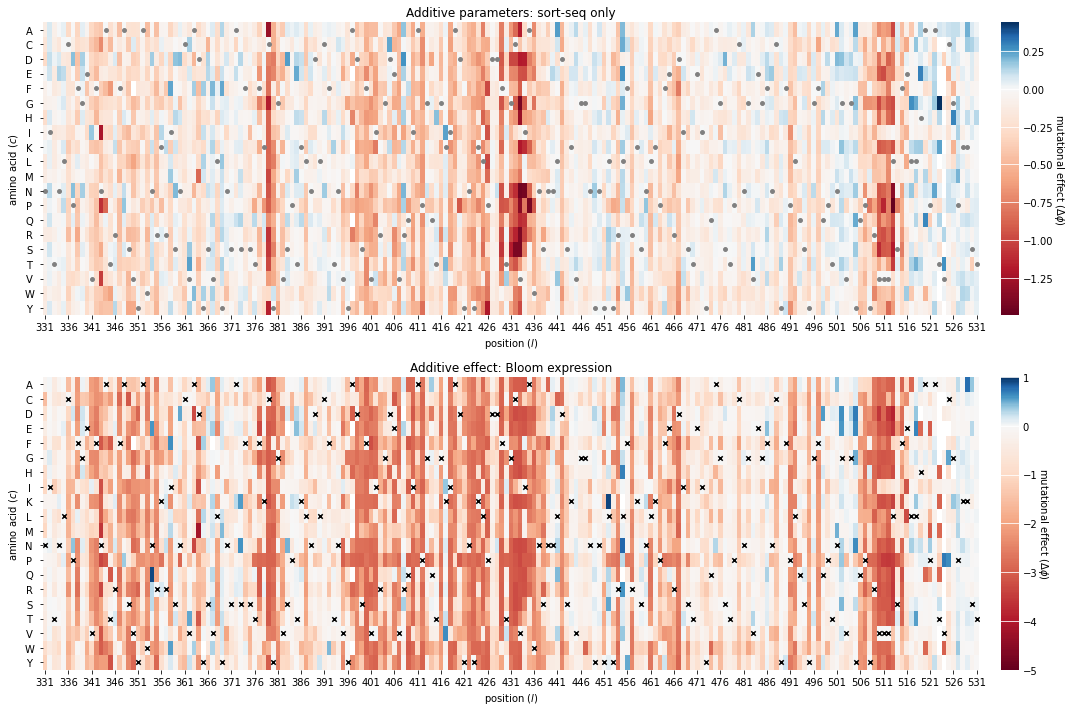

In [44]:

# Create figure
fig, axs = plt.subplots(2,1, figsize=(15,10))

# Draw heatmap
ax = axs[0]

heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=theta_lc,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters: sort-seq only')
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
#fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

bloom_exp_df
# Create figure
#fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
ax = axs[1]

heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=bloom_exp_df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'black', 's':20,'marker':'x'},
                                cmap='RdBu',
                                cbar=True,
                                clim = [-5,1],
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive effect: Bloom expression')

heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

In [40]:
mavenn.heatmap?

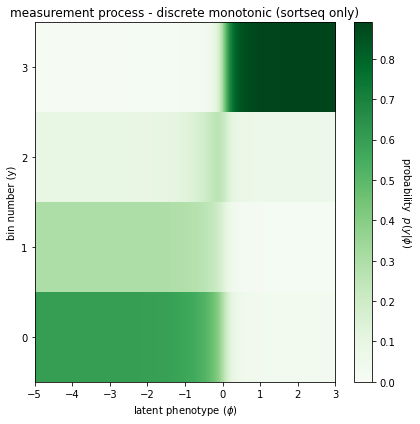

In [24]:
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)


# Create figure with two panels
fig, ax = plt.subplots(1,1,figsize=[6,6])

# Right panel: draw measurement process as heatmap
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process - discrete monotonic (sortseq only)')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()
fig.savefig('ace2rbd_mpa_measurment_prcoess_sortseq_only.png',dpi=300,bbox_inches='tight')


In [25]:
np.save('sortseq_gpmap_monotonic_agnostic',logo.df.values.ravel())
#np.save('sortseq_gpmap_discrete_agnostic',theta.ravel())